# Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
from datetime import date, datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Read Data

In [2]:
listing_df = pd.read_csv('listings.csv')
rating_df = pd.read_csv('reviews_rating.csv')

# Attribute Information

<i>Gathered from pandas profiling report</i> 
- Each row represents an airbnb listing

<style type="text/css">
.tg  {border:none;border-collapse:collapse;border-spacing:0;}
.tg td{border-style:solid;border-width:0px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;
  padding:10px 5px;word-break:normal;}
.tg th{border-style:solid;border-width:0px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-26t5{border-color:#fd6864;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-8zwo{font-style:italic;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-26t5">Column Name</th>
    <th class="tg-26t5">Description</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-8zwo">id</td>
    <td class="tg-0lax">id of listing</td>
  </tr>
  <tr>
    <td class="tg-8zwo">name</td>
    <td class="tg-0lax">name of listing</td>
  </tr>
  <tr>
    <td class="tg-8zwo">host_id</td>
    <td class="tg-0lax">id of host (can be repeated as 1 host can have many listings)</td>
  </tr>
  <tr>
    <td class="tg-8zwo">host_name</td>
    <td class="tg-0lax">name of host</td>
  </tr>
  <tr>
    <td class="tg-8zwo">neighbourhood_group</td>
    <td class="tg-0lax">5 regions (Central, West, East, Northeast, North)</td>
  </tr>
  <tr>
    <td class="tg-8zwo">neighbourhood</td>
    <td class="tg-0lax">43 distinct neighbourhoods (e.g Kallang)</td>
  </tr>
  <tr>
    <td class="tg-8zwo">latitude</td>
    <td class="tg-0lax">X position on the map</td>
  </tr>
  <tr>
    <td class="tg-8zwo">longitude</td>
    <td class="tg-0lax">Y position on the map</td>
  </tr>
  <tr>
    <td class="tg-8zwo">room_type</td>
    <td class="tg-0lax">3 types of room (Average Price: Entire Home > Private > Shared)</td>
  </tr>
  <tr>
    <td class="tg-8zwo">price</td>
    <td class="tg-0lax">price of room (range from 0 to 10000)</td>
  </tr>
  <tr>
    <td class="tg-8zwo">minimum_nights</td>
    <td class="tg-0lax">minimum no. of nights guest has to stay</td>
  </tr>
  <tr>
    <td class="tg-8zwo">number_of_reviews</td>
    <td class="tg-0lax">number of reviews for this listing</td>
  </tr>
  <tr>
    <td class="tg-8zwo">last_review</td>
    <td class="tg-0lax">last reviewed date (may be missing due to no reviews)</td>
  </tr>
  <tr>
    <td class="tg-8zwo">reviews_per_month</td>
    <td class="tg-0lax">No. of reviews posted on listing per month</td>
  </tr>
  <tr>
    <td class="tg-8zwo">calculated_host_listings_count</td>
    <td class="tg-0lax">Actual number of host listings - another metric to measure host experience or to distinguish business from individual</td>
  </tr>
  <tr>
    <td class="tg-8zwo">availability_365</td>
    <td class="tg-0lax">No. of days in a year it was made available at that point in time</td>
  </tr>
</tbody>
</table>

# Data Preprocessing

In [3]:
# Label encoding of room type 
def label_encoding(type):
  if (type == 'Entire home/apt'):
    return 2
  elif (type == "Private room"):
    return 1
  else:
    return 0

listing_df['room_type_label'] = listing_df['room_type'].apply(label_encoding)

# One hot encoding of neighbourhood_group
one_hot = pd.get_dummies(listing_df['neighbourhood_group'], dtype=int)
listing_df = listing_df.drop(['neighbourhood_group'],axis = 1)
listing_df = listing_df.join(one_hot)

# # Binary encoding of neighbourhood
binary=ce.BinaryEncoder(cols=['neighbourhood'])
listing_df=binary.fit_transform(listing_df)

# One hot encoding of neighbourhood 
# one_hot = pd.get_dummies(listing_df['neighbourhood'], dtype=int)
# listing_df = listing_df.drop(['neighbourhood'],axis = 1)
# listing_df = listing_df.join(one_hot)

# Fill na with 0 for reviews per month
listing_df['reviews_per_month'] = listing_df['reviews_per_month'].fillna(0)

# Transform last_review to days since last review
def get_last_day(review_date):
    current_date = datetime.strptime('2019-8-27', '%Y-%m-%d')
    delta = current_date - review_date
    return delta.days

listing_df['last_review'] = pd.to_datetime(listing_df['last_review'])
listing_df['last_review'] = listing_df['last_review'].fillna(datetime.strptime('2013-10-20', '%Y-%m-%d'))
listing_df['last_day_review'] = listing_df['last_review'].apply(get_last_day)

# add sentiment rating
combined_df = pd.merge(listing_df, rating_df, how='left', left_on='id', right_on='listing_id')
combined_df['sentiment_rating'] = combined_df['sentiment_rating'].fillna(0)
# Drop irrelevant columns
combined_df = combined_df.drop(columns=['id', 'host_id', 'host_name', 'name', 
                                    'last_review', 'sentiment_rating',
                                    'room_type', 'listing_id'
                                    ])

# Set price as last column
col_name = 'price'
price_col = combined_df.pop(col_name)
combined_df['price'] = price_col

# Removal of outliers

In [4]:
# Remove minimum nights more than a year
combined_df = combined_df[combined_df['minimum_nights']<=365]

# Remove price of listing equals zero
combined_df = combined_df[combined_df['price'] != 0]

# Remove prices above 500
combined_df = combined_df[combined_df['price'] <= 500]

# Remove listings that have zero reviews
# combined_df = combined_df[combined_df['number_of_reviews']==0]

# # Remove outliers for latitude, 3 std dev away from mean 
# std=np.std(combined_df['latitude'])
# mean=np.mean(combined_df['latitude'])
# median=np.median(combined_df['latitude'])
# outliers=[]
# for x in combined_df['latitude']:
#     zscore=(x-mean)/std
#     if zscore>abs(3):
#         outliers.append(x)
# combined_df = combined_df.replace(outliers,median)

# # Remove outliers for latitude, 3 std dev away from mean 
# std=np.std(combined_df['longitude'])
# mean=np.mean(combined_df['longitude'])
# median=np.median(combined_df['longitude'])
# outliers=[]
# for x in combined_df['longitude']:
#     zscore=(x-mean)/std
#     if zscore>abs(3):
#         outliers.append(x)
# combined_df = combined_df.replace(outliers,median)

In [5]:
cols = [
 'latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'room_type_label',
 'last_day_review',
 'price']
Q1 = combined_df[cols].quantile(0.25)
Q3 = combined_df[cols].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

latitude                             0.02646
longitude                            0.03754
minimum_nights                       9.00000
number_of_reviews                   11.00000
reviews_per_month                    0.88000
calculated_host_listings_count      46.00000
availability_365                   301.00000
room_type_label                      1.00000
last_day_review                   2105.00000
price                              124.00000
dtype: float64


In [6]:
combined_df = combined_df[~((combined_df < (Q1 - 1.5 * IQR)) |(combined_df > (Q3 + 1.5 * IQR))).any(axis=1)]
print(combined_df.shape)

(3638, 22)


In [9]:
combined_df.describe()

,neighbourhood_0,neighbourhood_1,neighbourhood_2,neighbourhood_3,neighbourhood_4,neighbourhood_5,neighbourhood_6,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_label,Central Region,East Region,North Region,North-East Region,West Region,last_day_review,price
count,3638.0,3638.000000,3638.000000,3638.000000,3638.000000,3638.000000,3638.000000,3638.000000,3638.000000,3638.000000,3638.000000,3638.000000,3638.000000,3638.000000,3638.000000,3638.000000,3638.000000,3638.000000,3638.000000,3638.0,3638.000000,3638.000000
mean,0.0,0.006872,0.452446,0.292743,0.631391,0.410390,0.418911,1.305204,103.854949,4.184442,4.093183,0.344252,28.848543,198.164101,1.420836,0.928807,0.053051,0.004398,0.013744,0.0,948.040132,137.264981
std,0.0,0.082623,0.497802,0.455084,0.482494,0.491972,0.493449,0.016639,0.027779,4.741989,6.149485,0.482491,36.402281,153.380707,0.629820,0.257182,0.224166,0.066181,0.116442,0.0,945.660189,83.440301
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.256390,103.780520,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,14.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.293452,103.838970,1.000000,0.000000,0.000000,2.000000,17.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,57.000000,69.000000
50%,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.308060,103.851510,2.000000,1.000000,0.120000,11.000000,243.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,406.500000,119.000000
75%,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.315008,103.870540,5.000000,5.000000,0.520000,43.000000,356.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.0,2137.000000,192.000000
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.361580,103.929800,22.000000,27.000000,2.200000,114.000000,365.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.0,2137.000000,375.000000


In [10]:
combined_df = combined_df.drop(columns=['neighbourhood_0', 'West Region'])

# Plotting

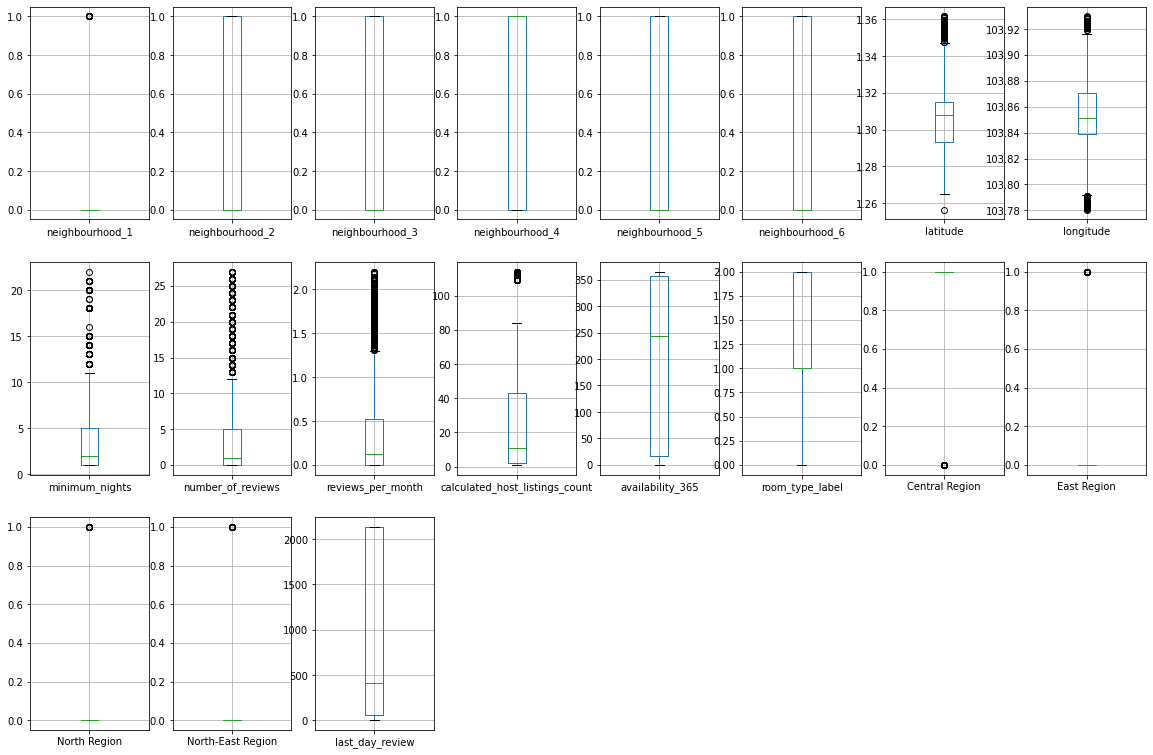

In [13]:
names=list(combined_df.columns) 
plt.figure(figsize=(20,18))
for i in range(1,20):
    
    plt.subplot(4,8,i)
    fig=combined_df.boxplot(column=names[i-1])

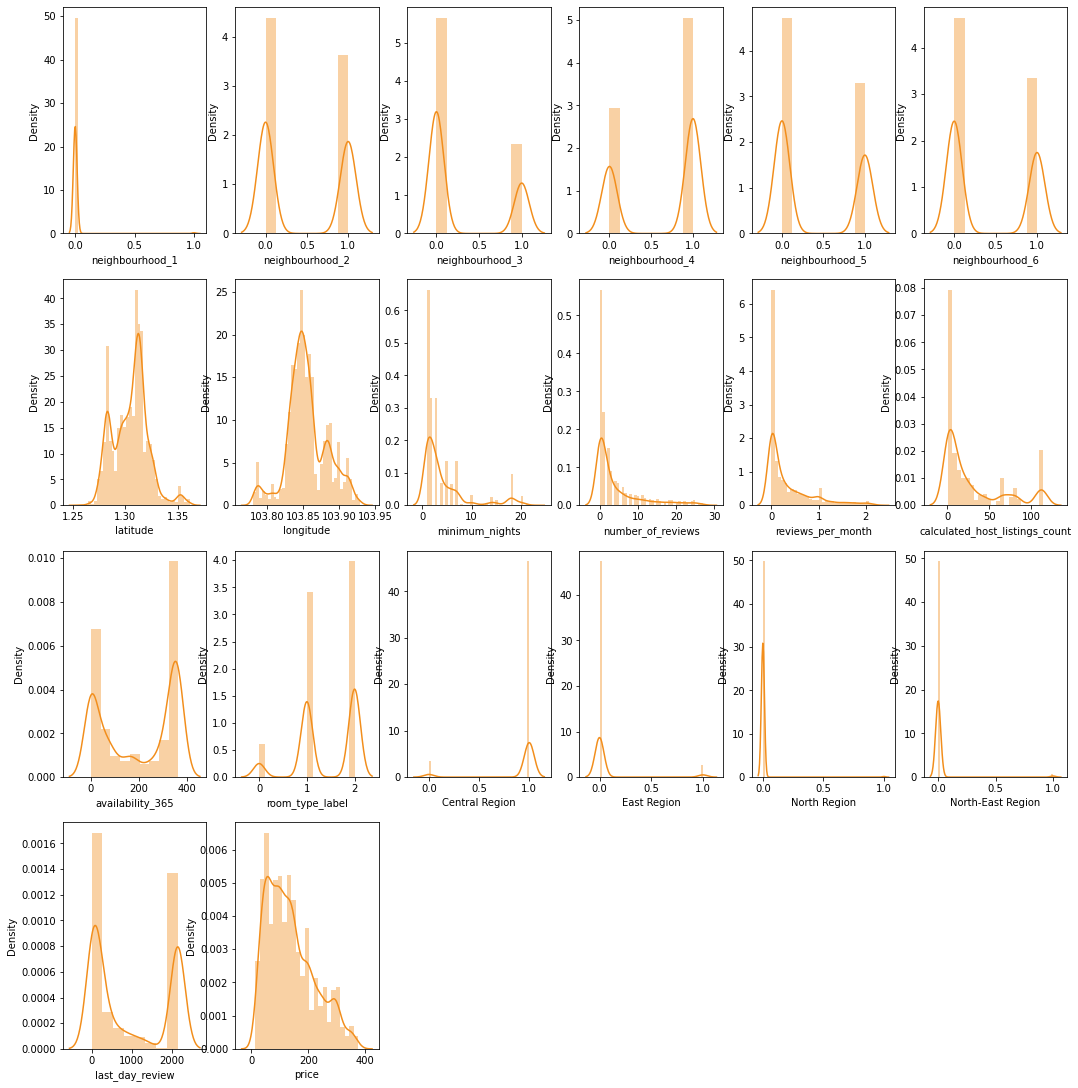

In [14]:
l = combined_df.columns.values
number_of_columns=6
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(3*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(combined_df[l[i]],kde=True, color='#f28e1c') 

# Save as dataset

In [13]:
# combined_df.to_csv('dataset_8.csv', index=False)